 ## Implémentez un Modèle de Scoring

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.



L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

##### Vous aurez sûrement besoin de joindre les différentes tables entre elles.


##### Votre mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.

Michaël, votre manager, vous incite à sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Vous analyserez ce kernel et l’adapterez pour vous assurer qu’il répond aux besoins de votre mission.

Vous pourrez ainsi vous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.

##### Spécifications du dashboard
Michaël vous a fourni des spécifications pour le dashboard interactif. Celui-ci devra contenir au minimum les fonctionnalités suivantes :

*Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.

*Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).

*Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

##### Livrables 

*Le dashboard interactif répondant aux spécifications ci-dessus et l’API de prédiction du score, déployées chacunes sur le cloud.

*Un dossier sur un outil de versioning de code contenant :

-Le code de la modélisation (du prétraitement à la prédiction)

-Le code générant le dashboard

-Le code permettant de déployer le modèle sous forme d'API

*Une note méthodologique décrivant :

-La méthodologie d'entraînement du modèle (2 pages maximum)

-La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)

-L’interprétabilité globale et locale du modèle (1 page maximum)

-Les limites et les améliorations possibles (1 page maximum)

*Un support de présentation pour la soutenance, détaillant le travail réalisé.


##### Définition: Le risque de défaut mesure la probabilité qu'un emprunteur ne rembourse pas ses obligations de prêt.

## 1- Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load 
import pylab as pl
import pickle
import gc
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

C:\Users\33768\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\33768\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\33768\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## 2- Chargement des jeux des données

In [2]:
app_test = pd.read_csv('application_test.csv', encoding='utf-8')
app_train = pd.read_csv('application_train.csv', encoding='utf-8')
bureau = pd.read_csv('bureau.csv', encoding='utf-8')
bureau_balance = pd.read_csv('bureau_balance.csv', encoding='utf-8')
credit_card_balance = pd.read_csv('credit_card_balance.csv', encoding='utf-8')
#HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv', encoding='utf-8')
installments_payments = pd.read_csv('installments_payments.csv', encoding='utf-8')
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv', encoding='utf-8')
previous_application = pd.read_csv('previous_application.csv', encoding='utf-8')
sample_submission = pd.read_csv('sample_submission.csv', encoding='utf-8')

### Exploratory Data Analysis (EDA) ou Analyse exploratoire des données

L'analyse exploratoire des données (EDA) est un processus où nous calculons des statistiques et faisons des figures pour trouver des tendances, des anomalies, des modèles ou des relations dans les données. L'objectif d'EDA est d'apprendre ce que nos données peuvent nous dire. Cela commence généralement par une vue d'ensemble, puis se réduit à des domaines spécifiques au fur et à mesure que nous trouvons des zones de données intrigantes. Les résultats peuvent être intéressants en eux-mêmes, ou ils peuvent être utilisés pour éclairer nos choix de modélisation, par exemple en nous aidant à décider des fonctionnalités à utiliser.

In [3]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Les données d'apprentissage (training data) comportent 307 511 observations et 122 variables, y compris notre variable cible: TARGET (variable que nous voulons prédire).

Notre variable target peut prendre 2 valeurs (0: le crédit a été remboursé; 1: le crédit n'a pas été remboursé).

In [4]:
# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Les données test (testing data) sont plus petites et ne possèdent pas la variable cible TARGET. Elles comportent 48744 obsevations et 121 variables.

In [5]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [7]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [8]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [9]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [10]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
sample_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


In [12]:
## Création d'une liste des jeux de données

data_list = [app_test, app_train, bureau, bureau_balance, credit_card_balance, 
             installments_payments, POS_CASH_balance, previous_application, sample_submission]

In [13]:
for data in data_list:
    print(data.shape)

(48744, 121)
(307511, 122)
(1716428, 17)
(27299925, 3)
(3840312, 23)
(13605401, 8)
(10001358, 8)
(1670214, 37)
(48744, 2)


In [14]:
for data in data_list:
    print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM 

In [15]:
for data in data_list:
    print(data.columns.tolist())

['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG

#### Pour les besoins de notre étude, nous nous concentrerons sur les fichiers application_train.csv et application_test.csv, qui contiennent une quantité importante d'informations utiles pour prédire le défaut de crédit.

### Examinons la distribution de notre variable d'étude

Notre variable d'étude est TARGET, c'est ce qu'on nous demande de prévoir : soit un 0 si le prêt a été remboursé à temps, soit un 1 indiquant que le client a eu des difficultés de paiement. Nous pouvons d'abord examiner le nombre de prêts entrant dans chaque catégorie.

In [16]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

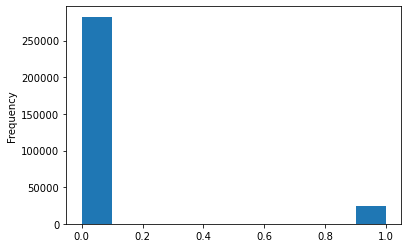

In [18]:
app_train['TARGET'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

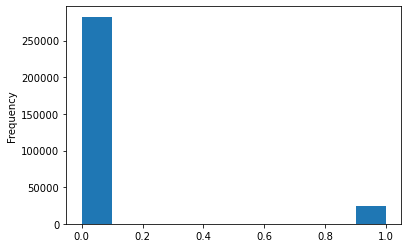

In [19]:
app_train['TARGET'].astype(int).plot.hist()

% de prêt remboursé


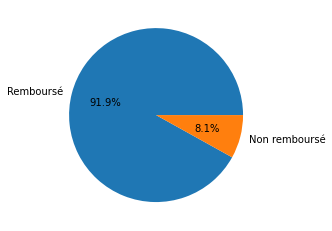

In [20]:
target_cent_train=app_train['TARGET'].value_counts()/len(app_train)*100

print('% de prêt remboursé')
plt.pie(target_cent_train,
        autopct='%1.1f%%',
        labels=["Remboursé", "Non remboursé"]
           )
plt.show()

Comme nous pouvons le constater, nous avons un problème de classes déséquilibrées (imbalanced class). Il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n'ont pas été remboursés. Ainsi, une pondération s'imposera dans la suite afin de résoudre ce problème.

In [21]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [22]:
# Nombre de classes uniques dans chaque colonne d'objet
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Nos variables catégorielles ont un nombre relativement faible d'entrées uniques. Nous devrons trouver un moyen de les traiter.

### Valeurs manquantes

In [23]:
#Fonction pour calculer les valeurs manquantes 

def missing_values_table(df):
        # Total des valeurs manquantes
        mis_val = df.isnull().sum()
        
        # Pourcentage des valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Table des résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renommer les colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Tri du tableau par pourcentage décroissant
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Quelques informations
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
        

In [24]:
# Valeurs manquantes
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [25]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [26]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

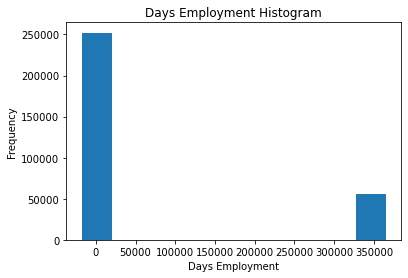

In [27]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [28]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


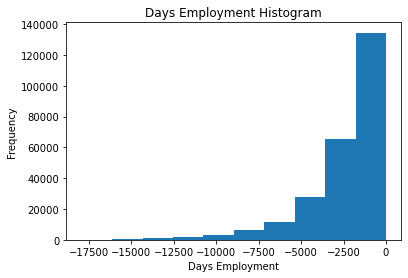

In [29]:
# Créer une colonne d'indicateur d'anomalie
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Remplacer les valeurs anormales par nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [30]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [31]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


### Correlation de Pearson

In [32]:
def heatmap_pearson(frame,v_max,v_min,v_centre):

  final_data_pears=frame.corr(method='pearson')
  #coupe en deux le heatmap
  mask = np.triu(np.ones_like(final_data_pears, dtype=np.bool))
  f, ax = plt.subplots(figsize=(22, 22))

  # couleur
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(final_data_pears, mask=mask, cmap=cmap, vmax=v_max,vmin=v_min, center=v_centre,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [33]:
col_pears=[
 'TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'REGION_RATING_CLIENT',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3'
]

train_pears=app_train[col_pears].copy()
train_pears.shape

(307511, 19)

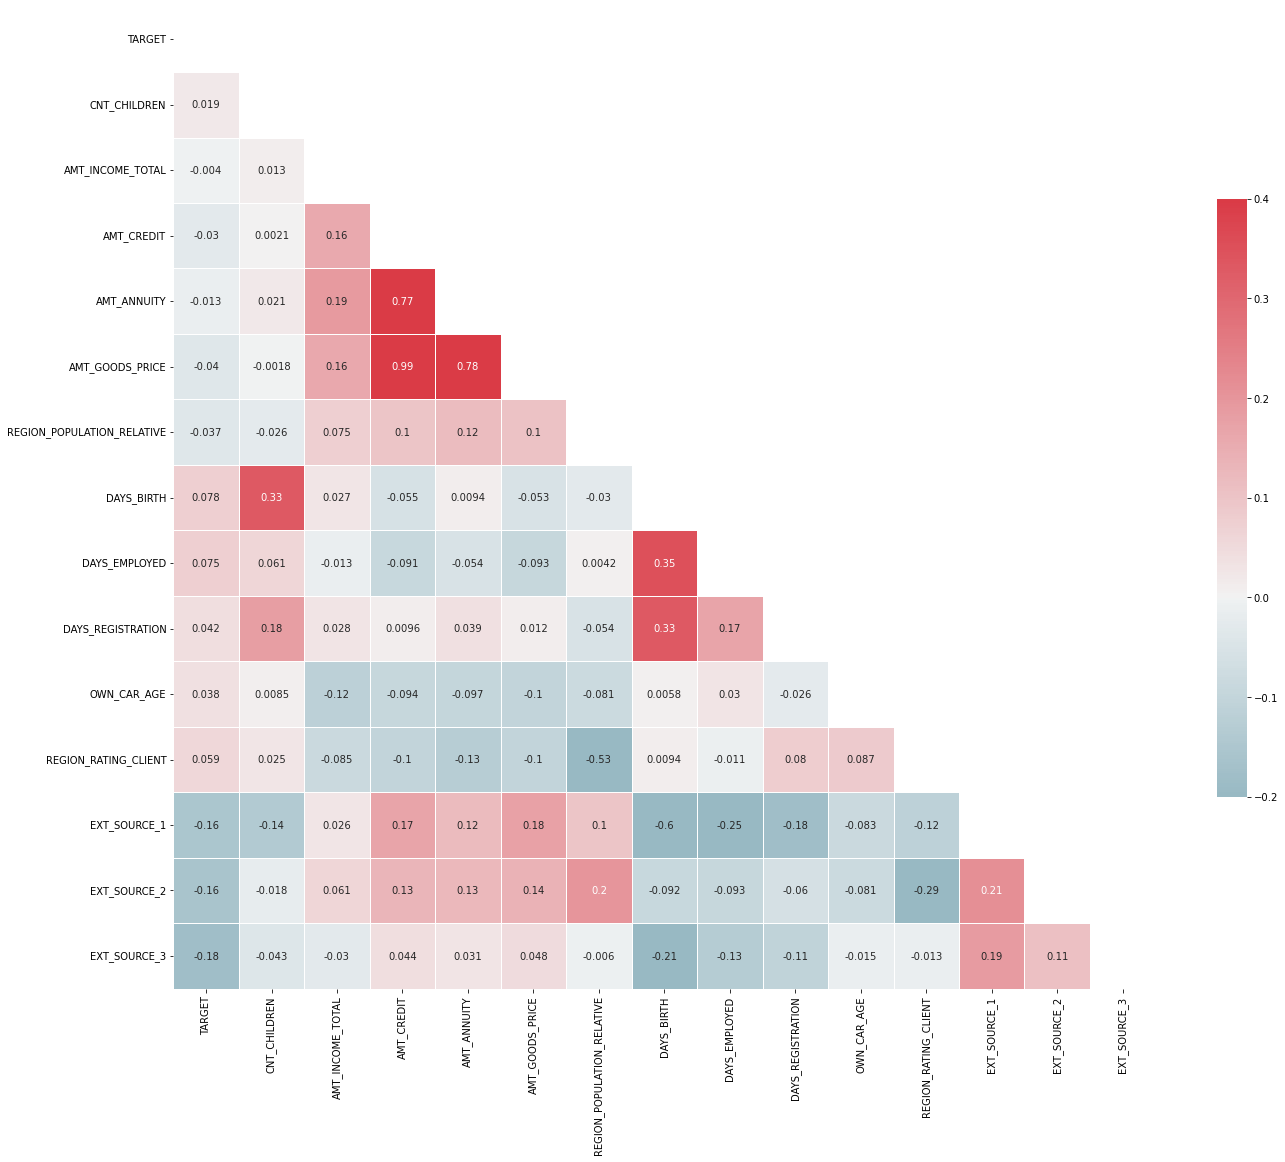

In [34]:
heatmap_pearson(train_pears,0.4,-0.2,0)

### Effet de l'âge sur le remboursement

In [35]:
#Corrélation entre les jours positifs depuis la naissance et target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982691

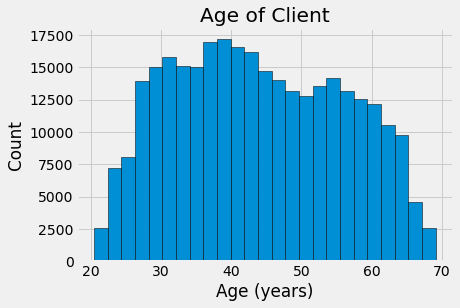

In [36]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

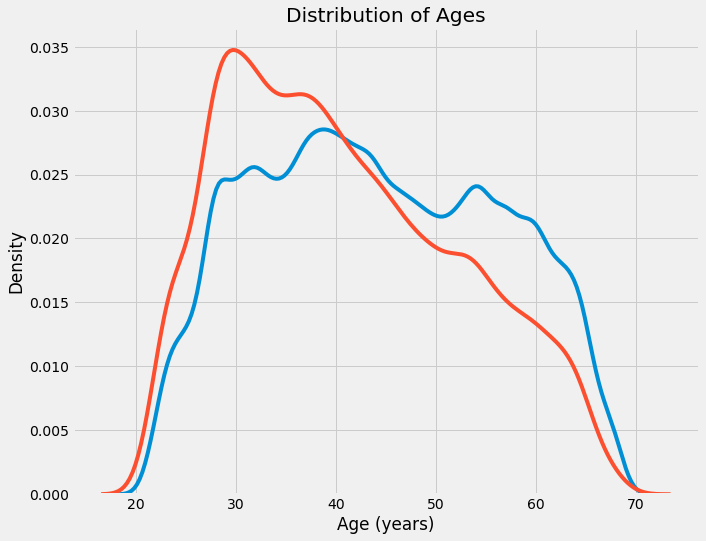

In [37]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [38]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [39]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


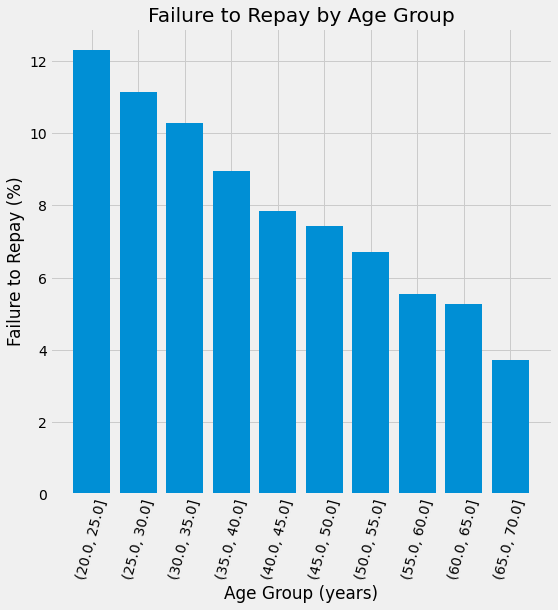

In [40]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

#### Exterior Sources

In [41]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


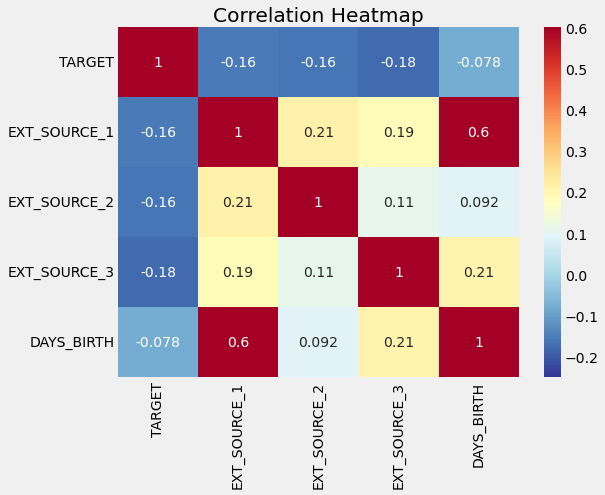

In [42]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

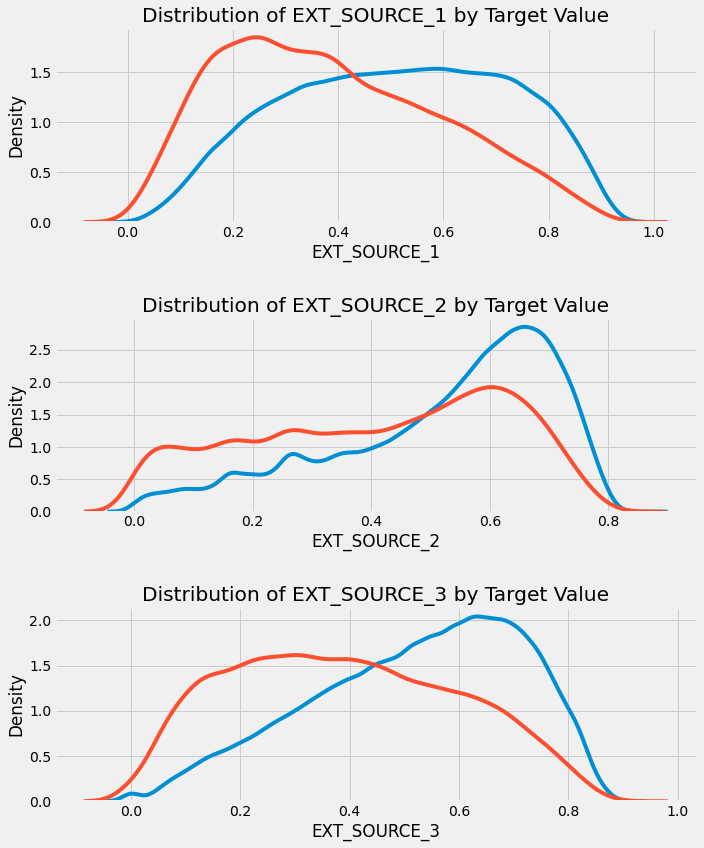

In [43]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

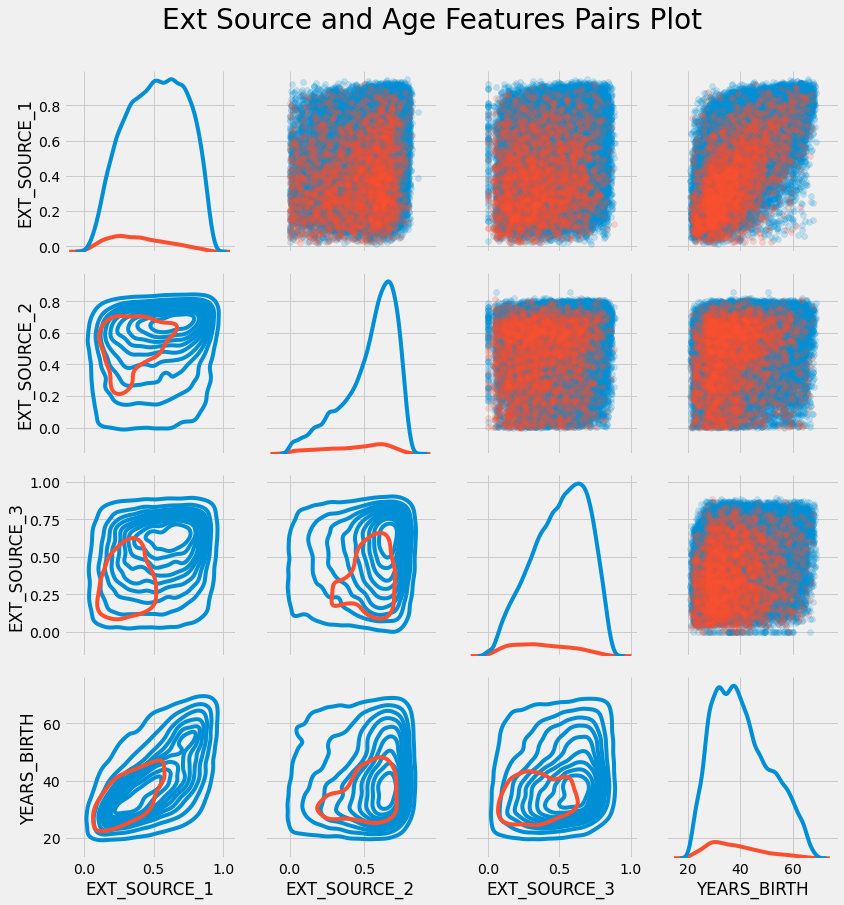

In [44]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 28, y = 1.05);

### Feature Engineering Train et Test

In [45]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)


# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)


Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


In [46]:
# Focntion pour nettoyer et encoder les données


def clean_data(train, test, encoding = 'ohe'):

    # Valeurs abérantes
    train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243
    test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

    train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

    #Création de feature
    app_train_domain = train.copy()
    app_test_domain = test.copy()

    app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
    app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
    app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
    app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

    app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
    app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
    app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
    app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

    features=app_train_domain.copy()
    test_features=app_test_domain.copy()

    # Extraction des ID
    train_ids = features['SK_ID_CURR'] 
    test_ids = test_features['SK_ID_CURR'] 
    
    # Extraction des Targets
    labels = features['TARGET']
   
    # Suppression des ID and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])

    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Alignement des dataframes 
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # label encoding
    elif encoding == 'le':
        
        # Creation du label encoder
        label_encoder = LabelEncoder()
        
        # Liste de stock indices
        cat_indices = []
        
        #Encodage
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                cat_indices.append(i)

    # Extraction des noms des Feature
    feat_name = list(features.columns)

    #Imputation des Nan 
    imputer = SimpleImputer(strategy = 'median')

    features = imputer.fit_transform(features)
    test_features = imputer.transform(test_features)

    # Scale les features
    scaler = MinMaxScaler(feature_range = (0, 1))

    features = scaler.fit_transform(features)
    test_features = scaler.transform(test_features)

    # Création des dataset
    features_set=pd.DataFrame(features,columns=feat_name)
    test_features_set=pd.DataFrame(test_features,columns=feat_name)

    # récupération des ID
    features_set['SK_ID_CURR']=train_ids
    test_features_set['SK_ID_CURR']=test_ids 
    
    # récupération des Targets
    features_set['TARGET']=labels

    print('Training Data Shape: ', features_set.shape)
    print('Testing Data Shape: ', test_features_set.shape)
    
    return features_set, test_features_set

In [47]:
train_set, test_set= clean_data(app_train, app_test, encoding = 'ohe')

Training Data Shape:  (307511, 248)
Testing Data Shape:  (48744, 247)


In [48]:
pickle.dump( train_set, open( "set_train.p", "wb" ) )
pickle.dump( test_set, open( "set_test.p", "wb" ) )

In [49]:
train_set = pickle.load( open( "set_train.p", "rb" ) )
test_set = pickle.load( open( "set_test.p", "rb" ) )

### Modélisation

In [50]:
import re # Regular expression module

train_set = train_set.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_set = test_set.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#Ajouter à cause de: LightGBMError: Do not support special JSON characters in feature name

In [51]:
# Split train validation

train_set_split, val_set, train_labels, val_labels = train_test_split(train_set.drop('TARGET',axis=1), 
                                                                      train_set['TARGET'], test_size = 0.2, random_state = 42)


In [52]:
train_set_split['TARGET']=train_labels
val_set['TARGET']=val_labels

In [53]:
train_set_split=train_set_split.reset_index(drop=True)

In [54]:
print('train shape :',train_set_split.shape)
print('validation shape :',val_set.shape)

train shape : (246008, 248)
validation shape : (61503, 248)


In [55]:
pickle.dump( train_set_split, open( "train_set_split.p", "wb" ) )
pickle.dump( val_set, open( "val_set.p", "wb" ) )

In [56]:
train_set_split = pickle.load( open( "train_set_split.p", "rb" ) )
val_set = pickle.load( open( "val_set.p", "rb" ) )

In [58]:
# Sauvegarde des jeux de données d'entrainement et de validation CSV
train_set_split.to_csv("train_set_split1.csv")
val_set.to_csv("valid_set1.csv")

### Optimisation Bayesienne + CV

In [59]:
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

In [60]:
def optimisation_baye(set_data,predictor,metric,n_folds = 5,smote=False,under=False,n_ite_baye = 15 ):

  data = set_data.copy()

  # Extraction des ID
  train_ids = data['SK_ID_CURR'] 

  # Extraction des targets
  targets = data['TARGET']
      
  # Remove the ids and target
  data = data.drop(columns = ['SK_ID_CURR', 'TARGET'])

  ### Fonction de cross validation
  def CV_kfol(X,Y,model_classific,metric,seuil_p,n_folds = 5,smote=False,under=False):

    features = X.copy()
    labels = Y.copy()        

    # Extraction des feature names
    feature_names = list(features.columns)
    
    # Convertion en np arrays
    features = np.array(features)        

    # Creation du kfold
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Vecteur vide pour feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Vecteur vide pour prediction sur validation
    prediction = np.zeros(features.shape[0])
    
    # Liste pour stocker les validation et training scores
    valid_scores = []
    
    # Boucle pour chaque fold
    n_boucl=0
    for train_indices, valid_indices in k_fold.split(features):
        n_boucl +=1
        #Avancement
        print('-'*45)
        print('Boucle: {} / {}'.format(n_boucl, n_folds))
        model = model_classific

        # Training data 
        train_features, train_labels = features[train_indices], labels[train_indices]

        #augmentation des data pour des meilleurs proportions
        if smote == True :

            sm = SMOTE(random_state=50) # sampling_strategy=0.2
            train_features, train_labels = sm.fit_resample(train_features, train_labels)  # sample ne marche pas        
                
            
        elif under == True :

            us = RandomUnderSampler(sampling_strategy='majority', random_state=50)
            train_features, train_labels = us.fit_resample(train_features, train_labels)  # sample ne marche pas

        # Validation data 
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Train du model
        model.fit(train_features, train_labels)
        
        # Récupération du best_iteration
        best_iteration = model.best_iteration_
        
        # Récupération des feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
                  
        # Récupération des predictions des validations 
        prediction[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Evaluation du model avec la metric
        valid_score = metric(labels[valid_indices],prediction[valid_indices],seuil_p)
        print('score de la boucle CV =',valid_score)
        
        # Récupération des best score
        valid_scores.append(valid_score)
        
        # Clean mémoire
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    return valid_scores#, feature_names, feature_importance_values


  ### Fonction a optimiser
  def optimize_rf(params,
                  model_optim=predictor,
                  X=data,
                  Y=targets,
                  metric=metric,
                  n_folds=n_folds,
                  smote=smote,
                  under=under
                  ):

    params_model = {'n_estimators': int(params['n_estimators']), 
                    'max_depth': int(params['max_depth']), 
                    'learning_rate': params['learning_rate'],
                    'subsample': params['subsample'],
                    'colsample_bytree': params['colsample_bytree'],
                    'num_leaves': int(params['num_leaves']),
                    'reg_alpha': params['reg_alpha'],
                    'reg_lambda': params['reg_lambda'],
    }
    
    model_optim.set_params(**params_model, class_weight = 'balanced')
    seuil_p = params['seuil']

    # Cross validation 
    valid_scor= CV_kfol(X,
                        Y,
                        model_optim,
                        metric,
                        seuil_p,
                        n_folds = n_folds,
                        smote = smote,
                        under = under
                        )
    
    # Moyenne des score de validation
    valid_loss_moy= 1-np.mean(valid_scor)

    print('-'*45)
    print('Perte optim =',valid_loss_moy)
    print('Score optim =',1-valid_loss_moy)
    print('-'*45)
    print('\n')
    print('-'*45)

    return valid_loss_moy


  # espace des parameters
  space={'n_estimators': hp.quniform('n_estimators', 200, 2000, 200),
          'max_depth' : hp.quniform('max_depth', 2, 30, 2),
          'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
          'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
          'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
          'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
          'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
          'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
          'seuil': hp.quniform('seuil', 0.0, 1.0, 0.025)
            }

  #Optimisation
  optim=fmin(fn=optimize_rf, 
                space=space, 
                algo=tpe.suggest, # selection des paramètre automatiquement
                max_evals=n_ite_baye, # nb iterations
      )

  # configuration du modèle avec les paramètres optimisés
  predictor.set_params(
                  n_estimators=int(optim['n_estimators']),
                  max_depth=int(optim['max_depth']),
                  learning_rate=optim['learning_rate'],
                  subsample=optim['subsample'],           
                  colsample_bytree=optim['colsample_by_tree'],
                  num_leaves=int(optim['num_leaves']),
                  reg_alpha=optim['reg_alpha'],
                  reg_lambda=optim['reg_lambda']
                    )

  # Entrainement du modèle sur tout le jeux de données 
  predictor.fit(data, targets)

  # Récupération des best parameters
  best_parameters = optim

  # Récupération des feature importances
  feature_importance_values = predictor.feature_importances_

  return best_parameters, feature_importance_values, predictor

### Metrique

In [61]:
def metric_banq ( y_true, y_pred, seuil=0.5, FN=-100, TP=0, TN=10, FP=-1):

# Liste des prédiction selon un seuil de probabilité
  y_seuil=[]

  for i in y_pred:
    if i >= seuil:
      y_seuil.append(1)
    elif i < seuil:
       y_seuil.append(0)

# Décompte des TP, FP, TN, FN 0 = solvable, 1 = non solvable
  # Matrice de Confusion
  mat_conf = confusion_matrix(y_true, y_seuil)

  fal_neg = mat_conf[1, 0]
  tru_po = mat_conf[1, 1]
  tru_neg = mat_conf[0, 0]  
  fal_po = mat_conf[0, 1]
  
  # Métric bancaire
  ### FN[1,0] ==> perte d'agent pour la banque ==> -100
  ### TP[1,1] ==> refus de prêt ==> 0
  ### TN [0,0] ==> prêt accordé, gain d'argent pour la banque ==> +10
  ### FP[0,1] ==> client perdu, perte d'argent pour la banque ==> -1

  # Gain
  tot = (tru_neg*TN + tru_po*TP + fal_neg*FN + fal_po*FP) 
  max_g = (tru_neg + fal_po)*TN + (tru_po + fal_neg)*TP
  min_g = (tru_neg + fal_po)*FP + (tru_po + fal_neg)*FN
  
  #Normalisation
  gain = (tot - min_g)/(max_g - min_g)

  return gain


### SAMPLING

### Class_weight

In [62]:
best_parameters_banq2, feature_importance_banq2, pred_model_banq2 = optimisation_baye(train_set_split,
                                                                             LGBMClassifier(),
                                                                             metric=metric_banq,
                                                                             n_ite_baye=15
                                                                             )

---------------------------------------------                                                                                       
Boucle: 1 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.5539106350645849                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 2 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.5593278964308255                                                   

0.6625051378054888                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 3 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6631292456302774                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 4 / 5                                                                                                                       
score de la boucle CV =                                              

score de la boucle CV =                                                                                                             
0.495840843537234                                                                                                                   
---------------------------------------------                                                                                       
Boucle: 5 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.4875911751463305                                                                                                                  
---------------------------------------------                                                                                       
Perte optim =                                                        

Perte optim =                                                                                                                       
0.44045434857519583                                                                                                                 
Score optim =                                                                                                                       
0.5595456514248042                                                                                                                  
---------------------------------------------                                                                                       
---------------------------------------------                                                                                       
---------------------------------------------                                                                                       
Boucle: 1 / 5                                                        

Boucle: 1 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6904068504352825                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 2 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6937328880194237                                                                                                                  
---------------------------------------------                        

---------------------------------------------                                                                                       
Boucle: 3 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6454272679613167                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 4 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6475425282616455                                                   

0.6513746721560437                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 5 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.662263619990995                                                                                                                   
---------------------------------------------                                                                                       
Perte optim =                                                                                                                       
0.34258003171164064                                                  

In [63]:
pickle.dump(pred_model_banq2, open('pred_model_banq2.md', 'wb'))

In [64]:
pred_model_banq2 = pickle.load( open( "pred_model_banq2.md", "rb" ) )

In [65]:
#Feature importances
feat_name=train_set_split.drop(['SK_ID_CURR', 'TARGET'],axis=1).columns
feat_valu=pred_model_banq2.feature_importances_
feat_frame=pd.DataFrame()
feat_frame['feature']=feat_name
feat_frame['importance']=feat_valu

In [66]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

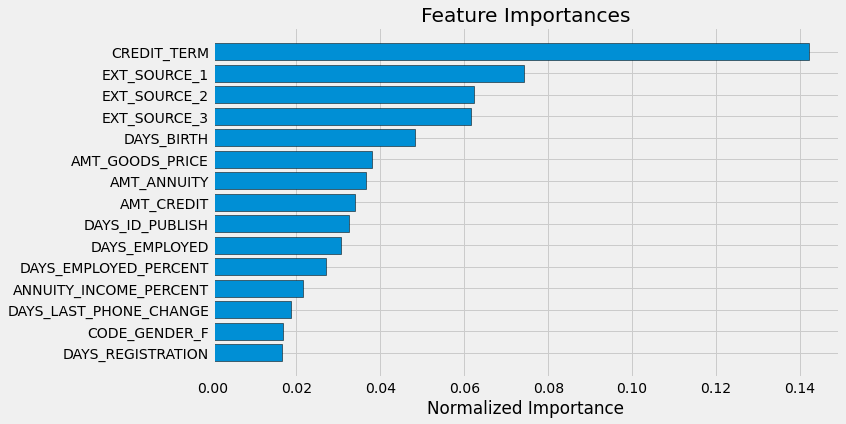

In [67]:
fi_sorted = plot_feature_importances(feat_frame)

### Seuil probabilité

([<matplotlib.axis.XTick at 0x1b035320ee0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

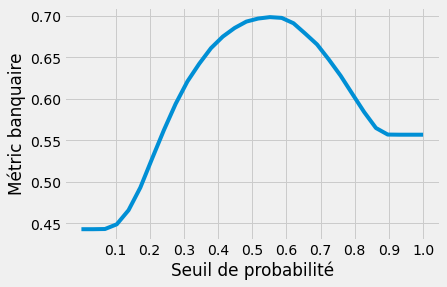

In [68]:
scor_int = []
int_seuil = np.linspace(0.0, 1, 30)

for s in int_seuil:
    
  # Score du modèle : 0 à 1
  y_scores = pred_model_banq2.predict_proba(val_set.drop(['SK_ID_CURR', 'TARGET'],axis=1))[:, 1]

  y_seuil=[]

  for i in y_scores:
    if i >= s:
      y_seuil.append(1)
    elif i < s:
       y_seuil.append(0)
    
  scor_int.append(metric_banq(val_set['TARGET'], y_seuil))
    
# Affichage du gain en fonction du seuil de solvabilité    
plt.plot(int_seuil, scor_int)
plt.xlabel("Seuil de probabilité")
plt.ylabel("Métric banquaire")
plt.xticks(np.linspace(0.1, 1, 10))

### Over sampling

In [69]:
best_parameters_banq_smot, feature_importance_banq_smot, pred_model_banq_smot = optimisation_baye(train_set_split,
                                                                             LGBMClassifier(),
                                                                             metric=metric_banq,
                                                                             smote=True,
                                                                             n_ite_baye=15
                                                                             )

---------------------------------------------                                                                                       
Boucle: 1 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.5830223111529026                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 2 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.5901457452232447                                                   

0.5822116259273318                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 3 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.578557963659078                                                                                                                   
---------------------------------------------                                                                                       
Boucle: 4 / 5                                                                                                                       
score de la boucle CV =                                              

score de la boucle CV =                                                                                                             
0.6482198322591802                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 5 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6433262044124268                                                                                                                  
---------------------------------------------                                                                                       
Perte optim =                                                        

Perte optim =                                                                                                                       
0.44291760502690525                                                                                                                 
Score optim =                                                                                                                       
0.5570823949730948                                                                                                                  
---------------------------------------------                                                                                       
---------------------------------------------                                                                                       
---------------------------------------------                                                                                       
Boucle: 1 / 5                                                        

Boucle: 1 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.5768011248047523                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 2 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.5879569839341103                                                                                                                  
---------------------------------------------                        

---------------------------------------------                                                                                       
Boucle: 3 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6763493993374307                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 4 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6770556896861345                                                   

0.5504962831418924                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 5 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.5608959927960379                                                                                                                  
---------------------------------------------                                                                                       
Perte optim =                                                                                                                       
0.44413029075591703                                                  

In [70]:
pickle.dump(pred_model_banq_smot, open('pred_model_banq_smot.md', 'wb'))

In [71]:
pred_model_banq_smot = pickle.load( open( "pred_model_banq_smot.md", "rb" ) )

### Under sampling

In [72]:
best_parameters_banq_under, feature_importance_banq_under, pred_model_banq_under = optimisation_baye(train_set_split,
                                                                             LGBMClassifier(),
                                                                             metric=metric_banq,
                                                                             under=True,
                                                                             n_ite_baye=15
                                                                             )

---------------------------------------------                                                                                       
Boucle: 1 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.584414947781697                                                                                                                   
---------------------------------------------                                                                                       
Boucle: 2 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.5801183211336188                                                   

0.687597842907807                                                                                                                   
---------------------------------------------                                                                                       
Boucle: 3 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6852483519425328                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 4 / 5                                                                                                                       
score de la boucle CV =                                              

score de la boucle CV =                                                                                                             
0.6894422606655981                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 5 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6962832057631697                                                                                                                  
---------------------------------------------                                                                                       
Perte optim =                                                        

Perte optim =                                                                                                                       
0.3562433288560587                                                                                                                  
Score optim =                                                                                                                       
0.6437566711439413                                                                                                                  
---------------------------------------------                                                                                       
---------------------------------------------                                                                                       
---------------------------------------------                                                                                       
Boucle: 1 / 5                                                        

Boucle: 1 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6614366662284503                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 2 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6637438262107814                                                                                                                  
---------------------------------------------                        

---------------------------------------------                                                                                       
Boucle: 3 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6350838250549352                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 4 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6428490665176819                                                   

0.6832866647600171                                                                                                                  
---------------------------------------------                                                                                       
Boucle: 5 / 5                                                                                                                       
score de la boucle CV =                                                                                                             
0.6917919855920757                                                                                                                  
---------------------------------------------                                                                                       
Perte optim =                                                                                                                       
0.3143137162687555                                                   

In [73]:
pickle.dump(pred_model_banq_under, open('pred_model_banq_under.md', 'wb'))

In [74]:
pred_model_banq_under = pickle.load( open( "pred_model_banq_under.md", "rb" ) )

### Comparaison sur le set_validation

In [75]:
#Dic de model:
dict_model_banq={'banq_class_weight':pred_model_banq2,
            'banq_Over_sampling':pred_model_banq_smot,
            'banq_Under_sampling':pred_model_banq_under,
                 }

#Fonction de prédiction sur le set de validation 
def scor_sampling_val (dico_model):
  name_sampl_val=[]
  scor_sampl_val=[]
  target_0=[]
  target_1=[]

  for i,j in dico_model.items():
    y_test_pred_proba=j.predict_proba(val_set.drop(['SK_ID_CURR', 'TARGET'],axis=1))[:, 1]
    name_sampl_val.append(i)
    scor_sampl_val.append(metric_banq(val_set['TARGET'],y_test_pred_proba))

    seuil=0.52 
    y_seuil_test=[]
    for i in y_test_pred_proba:
      if i >= seuil:
        y_seuil_test.append(1)
      elif i < seuil:
          y_seuil_test.append(0)

    pred_frame=pd.DataFrame(y_seuil_test)
    target_0.append((pred_frame.value_counts()/len(pred_frame)*100)[0].item())
    target_1.append((pred_frame.value_counts()/len(pred_frame)*100)[1].item())
   
  return name_sampl_val,scor_sampl_val,target_0,target_1

name_sampl_val_banq,scor_sampl_val_banq,target_0,target_1=scor_sampling_val(dict_model_banq)

#Tableau récap des scores
Scor_fram=pd.DataFrame()
Scor_fram['Sampling_banq']=name_sampl_val_banq
Scor_fram['score_banq']=scor_sampl_val_banq
Scor_fram['Pred_0']=target_0
Scor_fram['Pred_1']=target_1
Scor_fram

,Sampling_banq,score_banq,Pred_0,Pred_1
0,banq_class_weight,0.694898,70.417703,29.582297
1,banq_Over_sampling,0.698391,78.509991,21.490009
2,banq_Under_sampling,0.701902,74.532950,25.467050


In [76]:
val_frame_comp=Scor_fram.copy()
val_frame_comp['score_banq']=val_frame_comp['score_banq']*100
val_list={'Sampling_banq':'True_val','Pred_0':(val_set['TARGET'].value_counts()/len(val_set)*100)[0].item(),'Pred_1':(val_set['TARGET'].value_counts()/len(val_set)*100)[1].item()}
val_frame_comp=val_frame_comp.append(val_list,ignore_index=True)
val_frame_comp=val_frame_comp.set_index(val_frame_comp['Sampling_banq']).drop('Sampling_banq',axis=1)
val_frame_comp

,score_banq,Pred_0,Pred_1
Sampling_banq,,,
banq_class_weight,69.489809,70.417703,29.582297
banq_Over_sampling,69.839050,78.509991,21.490009
banq_Under_sampling,70.190171,74.532950,25.467050
True_val,NaN,91.953238,8.046762


<AxesSubplot:ylabel='Sampling_banq'>

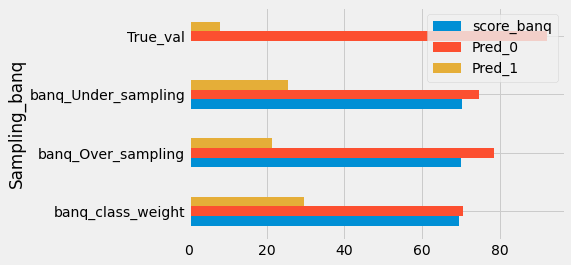

In [77]:
val_frame_comp.plot.barh()

### Prédiction sur le Test

In [78]:
pred_model_banq2.get_params

<bound method LGBMModel.get_params of LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.005794393545675628, max_depth=18,
               n_estimators=800, num_leaves=56, reg_alpha=0.9, reg_lambda=1.0,
               subsample=0.4)>

In [79]:
y_test_pred_proba=pred_model_banq2.predict_proba(test_set.drop(['SK_ID_CURR'],axis=1))[:, 1]

seuil=0.52 
y_seuil_test=[]

for i in y_test_pred_proba:
  if i >= seuil:
    y_seuil_test.append(1)
  elif i < seuil:
      y_seuil_test.append(0)

pred_frame=test_set.copy()
pred_frame['Proba']=y_test_pred_proba
pred_frame['TARGET']=y_seuil_test
pred_frame.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,SK_ID_CURR,Proba,TARGET
0,0.000000,0.000935,0.130787,0.073886,0.102132,0.257000,0.337542,0.869975,0.790451,0.887175,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,100001,0.395595,0
1,0.000000,0.000627,0.044387,0.061443,0.034792,0.491595,0.403890,0.750502,0.630431,0.774489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100005,0.558369,1
2,0.000000,0.001512,0.154373,0.265830,0.147026,0.260475,0.292616,0.751117,0.911843,0.513269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100013,0.150269,0
3,0.105263,0.002474,0.382022,0.184872,0.382716,0.361433,0.634329,0.895824,0.918936,0.415312,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,100028,0.290297,0
4,0.052632,0.001320,0.144944,0.118761,0.145903,0.134897,0.687091,0.877680,0.837873,0.407809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100038,0.653810,1


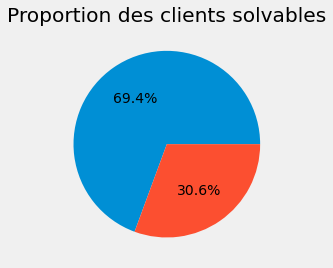

In [80]:
plt.title("Proportion des clients solvables")
plt.pie(pred_frame["TARGET"].value_counts(),
       autopct='%1.1f%%',
       radius=1)
plt.show()

In [81]:
pred_frame.to_csv('pred_frame.csv')

In [82]:
pred_frame=pd.read_csv('pred_frame.csv').drop('Unnamed: 0',axis=1)

### Interpretation

### Préparation du set pour Dashboard

In [84]:
pred_model_banq2 = pickle.load( open( "pred_model_banq2.md", "rb" ) )

In [85]:
val_set = pickle.load( open( "val_set.p", "rb" ) )

In [86]:
y_test_pred_proba=pred_model_banq2.predict_proba(val_set.drop(['SK_ID_CURR','TARGET'],axis=1))[:, 1]

seuil=0.52 
y_seuil_test=[]

for i in y_test_pred_proba:
  if i >= seuil:
    y_seuil_test.append(1)
  elif i < seuil:
      y_seuil_test.append(0)

pred_frame_dash=val_set.copy()
pred_frame_dash['Proba']=y_test_pred_proba
pred_frame_dash['PREDICTION']=y_seuil_test
pred_frame_dash.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,SK_ID_CURR,TARGET,Proba,PREDICTION
245895,0.105263,0.001550,0.104983,0.199000,0.094276,0.129331,0.672604,0.957459,0.974181,0.401556,...,0.0,0.0,0.0,0.0,0.0,0.0,384575,0,0.646453,1
98194,0.000000,0.001897,0.308792,0.184591,0.283951,0.090864,0.589121,0.936300,0.934744,0.368348,...,0.0,0.0,0.0,0.0,1.0,0.0,214010,0,0.276852,0
36463,0.000000,0.001512,0.112360,0.146227,0.113356,0.491595,0.412740,0.964326,0.898387,0.796999,...,0.0,0.0,0.0,0.0,0.0,0.0,142232,0,0.720194,1
249923,0.000000,0.001897,0.052360,0.090962,0.046016,0.635991,0.315840,0.610205,0.547382,0.561206,...,0.0,1.0,0.0,0.0,1.0,0.0,389171,0,0.101569,0
158389,0.000000,0.000742,0.065701,0.055563,0.048260,0.257000,0.276325,0.938310,0.704159,0.931360,...,0.0,0.0,1.0,0.0,1.0,0.0,283617,0,0.411495,0


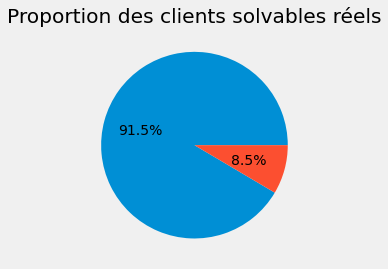

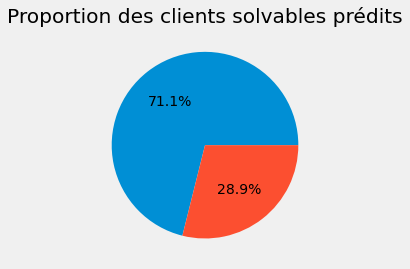

In [87]:
#Réduction de la taille du data set

pred_frame_dash_s1000=pred_frame_dash.sample(1000,random_state=42)
plt.title("Proportion des clients solvables réels")
plt.pie(pred_frame_dash_s1000["TARGET"].value_counts(),
       autopct='%1.1f%%',
       radius=1)
plt.show()
plt.title("Proportion des clients solvables prédits")
plt.pie(pred_frame_dash_s1000["PREDICTION"].value_counts(),
       autopct='%1.1f%%',
       radius=1)
plt.show()

In [88]:
pickle.dump(pred_frame_dash_s1000, open( "pred_frame_dash_s1000.p", "wb" ) )

In [89]:
pred_frame_dash_s1000 = pickle.load( open( "pred_frame_dash_s1000.p", "rb" ) )

In [90]:
pred_frame_dash_s1000.shape

(1000, 250)

### Shap

In [91]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#pip install numpy==1.21

In [92]:
import shap

In [93]:
ID_client=pred_frame_dash_s1000['SK_ID_CURR']

X_ID=pred_frame_dash_s1000[pred_frame_dash_s1000['SK_ID_CURR']==ID_client].copy()
X_ID=X_ID.reset_index(drop=True)
X=X_ID.drop(['SK_ID_CURR','Proba', 'TARGET','PREDICTION'],axis=1)
y_ID=X_ID['SK_ID_CURR']
y_Target=X_ID['TARGET']
y_proba=X_ID['Proba']
y_pred=X_ID['PREDICTION']


explainer = shap.TreeExplainer(pred_model_banq2)
shap_values = explainer.shap_values(X)

In [94]:
pickle.dump(shap_values, open( "shap_values.p", "wb" ) )

In [95]:
shap_values = pickle.load( open( "shap_values.p", "rb" ) )

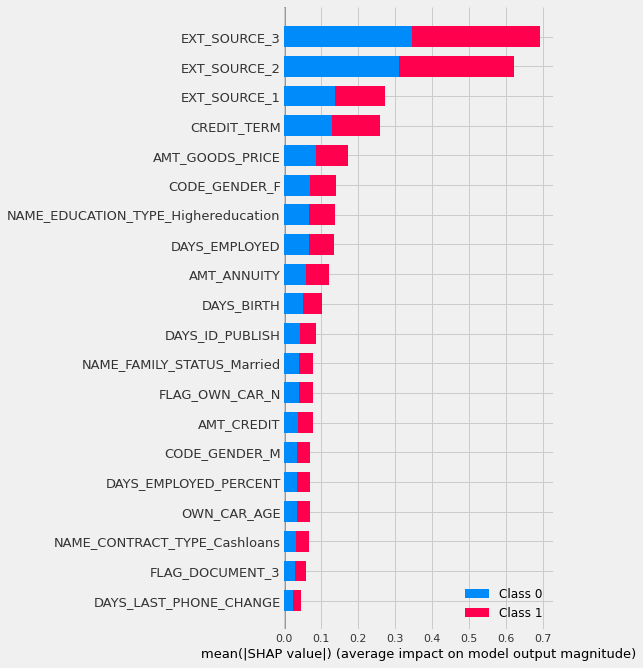

In [96]:
shap.summary_plot(shap_values, X)

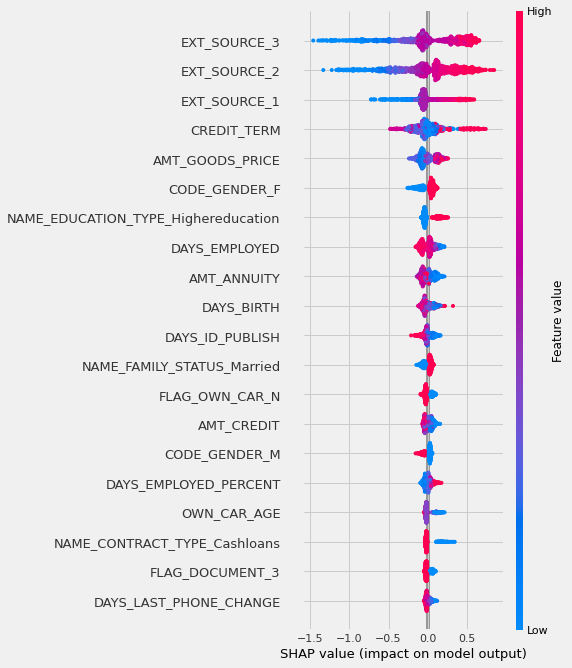

In [97]:
shap.summary_plot(shap_values[0], X)

In [98]:
# Client solvable 0
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][1,:], X.iloc[1,:])

In [99]:
# Client non solvable 1
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X.iloc[0,:])

In [100]:
### Frame avec les SHap values
set_shap=pd.DataFrame(shap_values[1],columns=X.columns)
set_shap['SK_ID_CURR']=y_ID
set_shap['TARGET']=y_Target
set_shap['Proba']=y_proba
set_shap['PREDICTION']=y_pred
set_shap.head(3)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,SK_ID_CURR,TARGET,Proba,PREDICTION
0,0.000130,0.002163,0.045549,0.086230,-0.129320,0.000105,0.039263,0.080983,-0.005929,-0.064684,...,-1.330316e-07,0.005423,-0.000239,0.0,0.001510,-0.000001,407405,1,0.750182,1
1,0.000707,0.000168,0.048374,0.059907,-0.137191,0.006911,-0.029082,-0.019891,0.000300,0.009373,...,-3.479774e-07,0.006168,0.003233,0.0,-0.001412,-0.000004,336258,0,0.376810,0
2,0.000290,-0.000149,0.039023,-0.017673,0.130651,-0.013836,0.074268,-0.101934,0.004477,-0.062402,...,-1.870148e-07,0.004673,-0.000469,0.0,0.000980,-0.000001,448283,0,0.686672,1


In [101]:
pickle.dump(set_shap, open( "set_shap.p", "wb" ) )

In [102]:
set_shap = pickle.load( open( "set_shap.p", "rb" ) )

### Comparaison globale

In [103]:
#Comparaison d'un client sur l'ensemble du set (moyenne)

def plot_ft_global(ID,frame_shap):
  id_num=ID
  ### Récupération des feat. les plus importants pour le client
  set_shap_id=frame_shap[frame_shap['SK_ID_CURR']==id_num].copy().T
  set_shap_id=set_shap_id.rename({frame_shap[frame_shap["SK_ID_CURR"]==id_num].index.item(): 'valeur'}, axis=1)
  set_shap_id=set_shap_id.drop(['SK_ID_CURR','Proba', 'TARGET','PREDICTION'],axis=0).sort_values(by='valeur')
  
  ft_ID_0=[]
  ft_ID_index_0=[]
  ft_ID_1=[]
  ft_ID_index_1=[]

  ft_ID_1.append(set_shap_id['valeur'][0])
  ft_ID_index_1.append(set_shap_id[set_shap_id['valeur']==ft_ID_1[0]].index.item())
  ft_ID_1.append(set_shap_id['valeur'][1])
  ft_ID_index_1.append(set_shap_id[set_shap_id['valeur']==ft_ID_1[1]].index.item())

  ft_ID_0.append(set_shap_id['valeur'][-1])
  ft_ID_index_0.append(set_shap_id[set_shap_id['valeur']==ft_ID_0[0]].index.item())
  ft_ID_0.append(set_shap_id['valeur'][-2])
  ft_ID_index_0.append(set_shap_id[set_shap_id['valeur']==ft_ID_0[1]].index.item())

  #Feat augmentant le risque

  #calcul des moyennes global pour les feat. les plus importants
  ft_moy_glob=[]
  ft_moy_0=[]
  ft_moy_1=[]
  ft_glob_index=[]

  for ft in ft_ID_index_1:
    ft_glob_index.append(ft)
    #moy global
    ft_moy_glob.append(frame_shap[ft].mean())
    #moy sur les client solvable
    ft_moy_0.append(frame_shap[frame_shap['TARGET']==0][ft].mean())
    #moy sur les client non solvable
    ft_moy_1.append(frame_shap[frame_shap['TARGET']==1][ft].mean())

  set_ft_glob=pd.DataFrame()
  set_ft_glob['feature']=ft_glob_index
  set_ft_glob['moy_global']=ft_moy_glob
  set_ft_glob['moy_0']=ft_moy_0
  set_ft_glob['moy_1']=ft_moy_1
  set_ft_glob['ID:'+str(id_num)]=ft_ID_1
  set_ft_glob=set_ft_glob.set_index(set_ft_glob['feature']).T.drop('feature')
  
  print('Comparaison des infos du client pour les features augmentant le risque')
  for ft in set_ft_glob.columns:
    print(ft)
    sns.barplot(y = set_ft_glob[ft].index,x=set_ft_glob[ft])
    plt.show()

  #feat diminuant le risque

  #calcul des moyennes global pour les feat. les plus importants
  ft_moy_glob=[]
  ft_moy_0=[]
  ft_moy_1=[]
  ft_glob_index=[]

  for ft in ft_ID_index_0:
    ft_glob_index.append(ft)
    #moy global
    ft_moy_glob.append(frame_shap[ft].mean())
    #moy sur les client solvable
    ft_moy_0.append(frame_shap[frame_shap['TARGET']==0][ft].mean())
    #moy sur les client non solvable
    ft_moy_1.append(frame_shap[frame_shap['TARGET']==1][ft].mean())

  set_ft_glob_0=pd.DataFrame()
  set_ft_glob_0['feature']=ft_glob_index
  set_ft_glob_0['moy_global']=ft_moy_glob
  set_ft_glob_0['moy_0']=ft_moy_0
  set_ft_glob_0['moy_1']=ft_moy_1
  set_ft_glob_0['ID:'+str(id_num)]=ft_ID_0
  set_ft_glob_0=set_ft_glob_0.set_index(set_ft_glob_0['feature']).T.drop('feature')

  print('Comparaison des infos du client pour les features diminuant le risque')
  for ft in set_ft_glob_0.columns:
    print(ft)
    sns.barplot(x = set_ft_glob_0[ft].index,y=set_ft_glob_0[ft])
    plt.show()


  return set_ft_glob,set_ft_glob_0

Comparaison des infos du client pour les features augmentant le risque
AMT_GOODS_PRICE


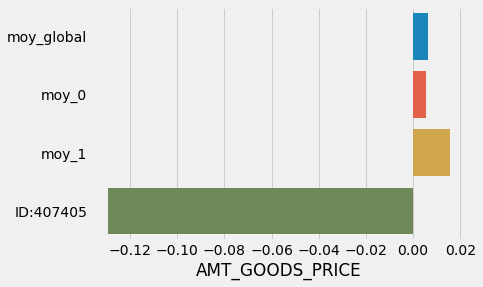

DAYS_ID_PUBLISH


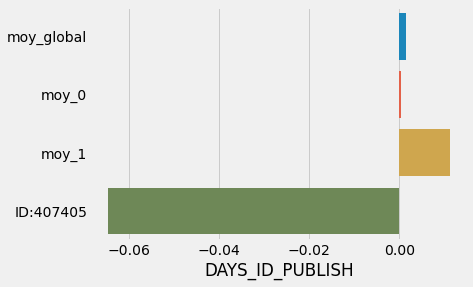

Comparaison des infos du client pour les features diminuant le risque
EXT_SOURCE_2


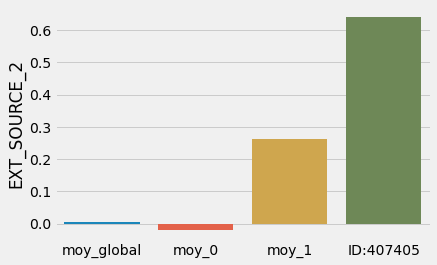

EXT_SOURCE_3


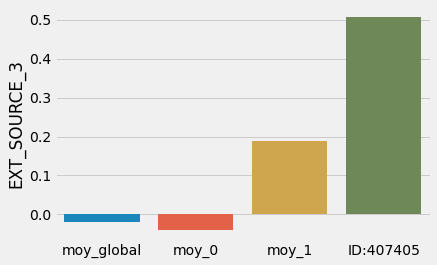

(feature    AMT_GOODS_PRICE DAYS_ID_PUBLISH
 moy_global         0.00632        0.001365
 moy_0             0.005466        0.000454
 moy_1             0.015516        0.011165
 ID:407405         -0.12932       -0.064684,
 feature    EXT_SOURCE_2 EXT_SOURCE_3
 moy_global     0.005244    -0.019369
 moy_0         -0.018571     -0.03864
 moy_1          0.261599     0.188079
 ID:407405      0.639015     0.505267)

In [104]:
plot_ft_global(407405, set_shap)

In [105]:
# Sampling du app_train pour récupérer (la) vraie valeur
tru_data=[]
for i in list(set_shap['SK_ID_CURR']):
  tru_data.append(app_train.iloc[app_train[app_train['SK_ID_CURR']==i].index.item(),:])

set_tru_data=pd.DataFrame(tru_data)
set_tru_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM
265413,407405,1,Cash loans,M,Y,Y,1,180000.0,1288350.0,37800.0,...,0,0,0,0.0,0.0,0.0,2.0,0.0,3.0,False
203790,336258,0,Cash loans,F,N,Y,0,261000.0,1436850.0,46350.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,True
300626,448283,0,Cash loans,F,N,Y,0,85050.0,545040.0,20677.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,False
200238,332126,0,Cash loans,F,N,Y,0,81000.0,598486.5,21627.0,...,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0,False
192250,322924,0,Cash loans,F,N,Y,0,112500.0,1178703.0,82165.5,...,0,0,0,0.0,0.0,1.0,0.0,2.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188756,318838,0,Cash loans,M,N,N,1,225000.0,508495.5,24462.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
223596,358980,0,Cash loans,F,N,Y,0,270000.0,1024290.0,30078.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,False
69851,181030,0,Revolving loans,F,N,N,0,90000.0,270000.0,13500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,7.0,False
173194,300705,0,Cash loans,F,Y,Y,0,157500.0,942300.0,27679.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,False


In [106]:
pickle.dump(set_tru_data, open( "set_tru_data.p", "wb" ) )

In [107]:
#Comparaison d'un client sur l'ensemble du set (distribution)

def hist_plot_global(ID,frame_shap,frame_cl):
  id_num=int(ID)
  ### Récupération des feat. les plus importants pour le client
  set_shap_id=frame_shap[frame_shap['SK_ID_CURR']==id_num].copy().T
  set_shap_id=set_shap_id.rename({frame_shap[frame_shap["SK_ID_CURR"]==id_num].index.item(): 'valeur'}, axis=1)
  set_shap_id=set_shap_id.drop(['SK_ID_CURR','Proba', 'TARGET','PREDICTION'],axis=0).sort_values(by='valeur')

  ft_ID_0=[]
  ft_ID_1=[]


  ft_ID_1.append(set_shap_id.index[0])
  ft_ID_1.append(set_shap_id.index[1])

  ft_ID_0.append(set_shap_id.index[-1])
  ft_ID_0.append(set_shap_id.index[-2])

  #Feat augmentant le risque

  #calcul des moyennes global pour les feat. les plus importants
  ft_moy_glob=[]
  ft_moy_0=[]
  ft_moy_1=[]
  ft_glob_index=[]
  ft_cl=[]
  print('Comparaison des infos du client pour les features augmentant le risque')
  for ft in ft_ID_1:
    print(ft)
    
    plt.style.use('seaborn-deep')

    x = frame_cl[frame_cl['TARGET']==0][ft]
    y = frame_cl[frame_cl['TARGET']==1][ft]
    z = frame_cl[ft]
    bins = np.linspace(0, 1, 10)

    risque_client=frame_cl[frame_cl['SK_ID_CURR']==id_num][ft].item()

    plt.hist([x, y,z], bins, label=['Solvable', 'Non solvable','Global'])
    plt.axvline(risque_client,linewidth=4, color='#28dbef')

    plt.legend(loc='upper right')
    plt.ylabel('Nb de client')
    plt.show()

  #feat diminuant le risque

  #calcul des moyennes global pour les feat. les plus importants
  ft_moy_glob=[]
  ft_moy_0=[]
  ft_moy_1=[]
  ft_glob_index=[]
  ft_cl=[]
  print('Comparaison des infos du client pour les features diminuant le risque')
  for ft in ft_ID_0:
    print(ft)
    
    plt.style.use('seaborn-deep')

    x = frame_cl[frame_cl['TARGET']==0][ft]
    y = frame_cl[frame_cl['TARGET']==1][ft]
    z = frame_cl[ft]
    bins = np.linspace(0, 1, 10)

    risque_client=frame_cl[frame_cl['SK_ID_CURR']==id_num][ft].item()

    plt.hist([x, y,z], bins, label=['Solvable', 'Non solvable','Global'])
    plt.axvline(risque_client,linewidth=4, color='#28dbef')

    plt.legend(loc='upper right')
    plt.ylabel('Nb de client')
    plt.show()

Comparaison des infos du client pour les features augmentant le risque
AMT_GOODS_PRICE


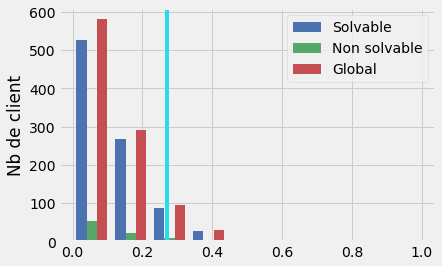

DAYS_ID_PUBLISH


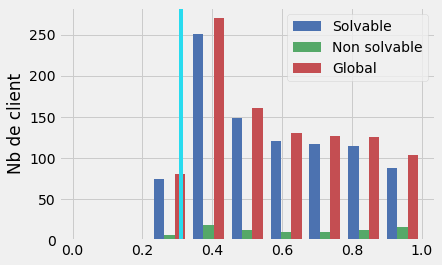

Comparaison des infos du client pour les features diminuant le risque
EXT_SOURCE_2


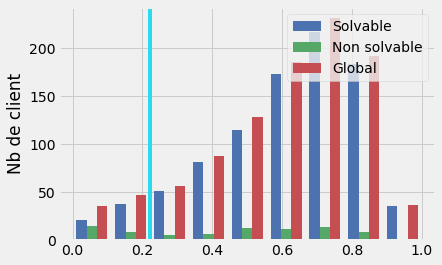

EXT_SOURCE_3


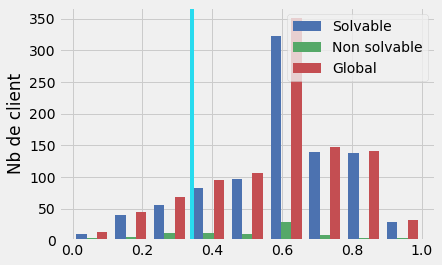

In [108]:
hist_plot_global(407405,set_shap,pred_frame_dash_s1000)

### Comparaison proche voisin

In [109]:
def comparaison_client_voisin(ID,frame_shap,frame_True,frame_hist):
  
  
  frame_shap['AGE']=round(frame_shap['DAYS_BIRTH'],1)
  frame_True['AGE']=round(abs(frame_True['DAYS_BIRTH']/365)).astype(int)
  
  ID_c=int(ID)

  #INFO CLIENT SHAP
  info_client=frame_shap[frame_shap['SK_ID_CURR']==ID_c]
  enfant_c=info_client['CNT_CHILDREN'].item()
  age_c=info_client['AGE'].item()
  genre_c=info_client['CODE_GENDER_M'].item()
  region_c=info_client['REGION_RATING_CLIENT'].item()
  
  #INFO CLIENT True
  info_client_t=frame_True[frame_True['SK_ID_CURR']==ID_c]
  enfant_c_t=info_client_t['CNT_CHILDREN'].item()
  age_c_t=info_client_t['AGE'].item()
  genre_c_t=info_client_t['CODE_GENDER'].item()
  region_c_t=info_client_t['REGION_RATING_CLIENT'].item()
  arr_cl=[]
  arr_cl.append(ID_c)
  arr_cl.append(age_c_t)
  arr_cl.append(genre_c_t)
  arr_cl.append(enfant_c_t)
  arr_cl.append(region_c_t)
  frame_info_client=pd.DataFrame(arr_cl)
  frame_info_client=frame_info_client.T
  frame_info_client.columns=['SK_ID_CURR','AGE','CODE_GENDER','CNT_CHILDREN','REGION_RATING_CLIENT']
  
  #PROCHE VOISIN
  enfant_v=frame_shap[frame_shap['CNT_CHILDREN']==enfant_c]
  age_v=enfant_v[enfant_v['AGE']==age_c]
  genre_v=age_v[age_v['CODE_GENDER_M']==genre_c]
  region_v=genre_v[genre_v['REGION_RATING_CLIENT']==region_c]

  if len(region_v) < 15:
    set_client_voisin=region_v.sample(len(region_v),random_state=42)
  if len(region_v) >= 15:
    set_client_voisin=region_v.sample(15,random_state=42)

  plt.barh(range(len(set_client_voisin)),set_client_voisin['Proba'])
  risque_client=info_client['Proba'].item()
  plt.axvline(x=risque_client,linewidth=8, color='#d62728')
  plt.xlabel('% de risque')
  plt.ylabel('Profils similaires')
  plt.show()

  moy_vois=set_client_voisin['Proba'].mean()
  diff_proba=round(abs(risque_client-moy_vois)*100,2)
  print('Le client',str(ID_c),'à un écart de',str(diff_proba),'% avec les clients de profils similaires')
  
  hist_plot_global(ID_c,frame_hist,set_client_voisin)

  return frame_info_client

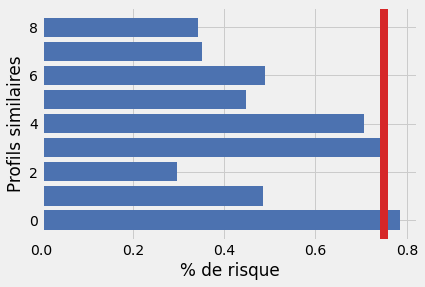

Le client 407405 à un écart de 23.3 % avec les clients de profils similaires
Comparaison des infos du client pour les features augmentant le risque
AMT_GOODS_PRICE


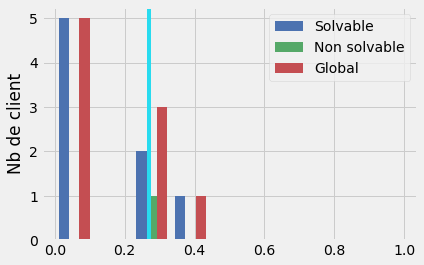

DAYS_ID_PUBLISH


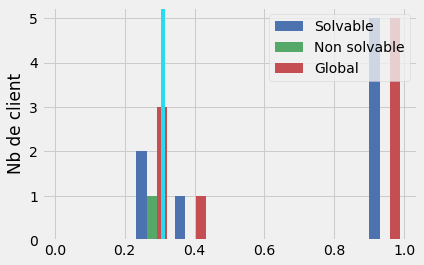

Comparaison des infos du client pour les features diminuant le risque
EXT_SOURCE_2


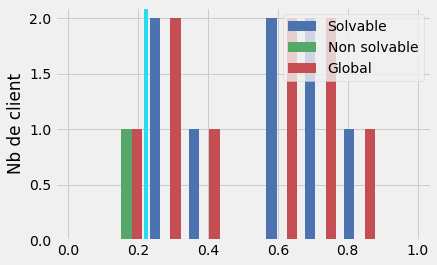

EXT_SOURCE_3


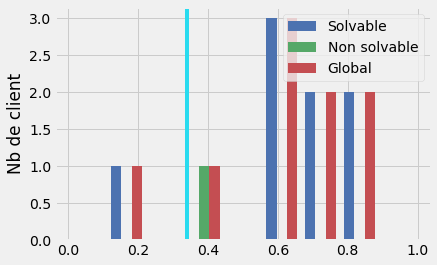

,SK_ID_CURR,AGE,CODE_GENDER,CNT_CHILDREN,REGION_RATING_CLIENT
0,407405,44,M,1,2


In [110]:
set_client_voisin_407405=comparaison_client_voisin(407405, pred_frame_dash_s1000,set_tru_data,set_shap)
set_client_voisin_407405

### Requirements 

In [111]:
from platform import python_version

print(python_version())

3.9.12


In [112]:
!pip show flask 

Name: Flask
Version: 1.1.2
Summary: A simple framework for building complex web applications.
Home-page: https://palletsprojects.com/p/flask/
Author: Armin Ronacher
Author-email: armin.ronacher@active-4.com
License: BSD-3-Clause
Location: c:\users\33768\anaconda3\lib\site-packages
Requires: itsdangerous, click, Werkzeug, Jinja2
Required-by: prometheus-flask-exporter, mlflow, Flask-WTF, Flask-RESTful, Flask-Compress, dash


In [114]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.5.1


In [115]:
import seaborn
print('seaborn: {}'.format(seaborn.__version__))

seaborn: 0.11.2


In [116]:
import streamlit
print('streamlit: {}'.format(streamlit.__version__))

streamlit: 1.13.0


In [117]:
!pip show lime

Name: lime
Version: 0.2.0.1
Summary: Local Interpretable Model-Agnostic Explanations for machine learning classifiers
Home-page: http://github.com/marcotcr/lime
Author: Marco Tulio Ribeiro
Author-email: marcotcr@gmail.com
License: BSD
Location: c:\users\33768\anaconda3\lib\site-packages
Requires: matplotlib, tqdm, scikit-learn, scikit-image, numpy, scipy
Required-by: 


In [118]:
!pip show imbalanced-learn

Name: imbalanced-learn
Version: 0.9.1
Summary: Toolbox for imbalanced dataset in machine learning.
Home-page: https://github.com/scikit-learn-contrib/imbalanced-learn
Author: 
Author-email: 
License: MIT
Location: c:\users\33768\anaconda3\lib\site-packages
Requires: scipy, numpy, threadpoolctl, joblib, scikit-learn
Required-by: imblearn


In [119]:
!pip show plotly

Name: plotly
Version: 5.6.0
Summary: An open-source, interactive data visualization library for Python
Home-page: https://plotly.com/python/
Author: Chris P
Author-email: chris@plot.ly
License: MIT
Location: c:\users\33768\anaconda3\lib\site-packages
Requires: tenacity, six
Required-by: dash
